In [1]:
import time, datetime
import copy
import os
import sys
import warnings
#warnings.filterwarnings("ignore", category=UserWarning)
#warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np
from loguru import logger
import yaml
from utils import dumb_reward_plot
import gym

sys.path.append('./envs/cartpole-envs')
sys.path.append('./')
import cartpole_envs
#import highway_env

from utils import plot_reward, plot_index
from mpc.mpc_cp import MPC
from baselines.NN import NN

def prepare_dynamics(gym_config):
    dynamics_name = gym_config['dynamics_name']
    seed = gym_config['seed']
    dynamics_set = []
    for i in range(len(dynamics_name)):
        env = gym.make(dynamics_name[i])
        # env.seed(seed)
        dynamics_set.append(gym.make(dynamics_name[i]))
    
    # use pre-defined env sequence
    task = [dynamics_set[i] for i in gym_config['task_dynamics_list']]
    return task

def load_config(config_path="config.yml"):
    if os.path.isfile(config_path):
        f = open(config_path)
        return yaml.load(f, Loader=yaml.FullLoader)
    else:
        raise Exception("Configuration file is not found in the path: "+config_path)


In [2]:
config = load_config('config/config_cp_nn_delay.yml')
nn_config = config['NN_config']
mpc_config = config['mpc_config']
gym_config = config['gym_config']
render = gym_config['render']

# initialize the mixture model
# model = DPGPMM(dpgp_config=dpgp_config)
# model = SingleSparseGP(sparse_gp_config=sparse_gp_config)
# model = SingleGP(gp_config=gp_config)
model = NN(NN_config=nn_config)
logger.info('Using model: {}', model.name)

# initial MPC controller
mpc_controller = MPC(mpc_config=mpc_config)

# prepare task
# the task is solved, if each dynamic is solved
task = prepare_dynamics(gym_config)
print(gym_config)

"""start DPGP-MBRL"""
data_buffer = []
label_list = []
subtask_list = []
subtask_reward = []
subtask_succ_count = [0]
comp_trainable = [1]
task_reward = []
trainable = True
task_solved = False
subtask_solved = [False, False, False, False]
total_count = 0
task_epi = 0
log_name = None

total_tasks = 1
max_delay_step = gym_config["max_delay_step"]

2020-05-24 17:11:58.852 | INFO     | __main__:<module>:12 - Using model: NN


{'render': False, 'task_dynamics_list': [0, 1, 2, 3], 'subtask_episode': 3, 'subtask_episode_length': 200, 'task_episode': 100, 'seed': 1000, 'dynamics_name': ['CartPoleSwingUpEnvCm05Pm04Pl05-v0', 'CartPoleSwingUpEnvCm05Pm04Pl07-v0', 'CartPoleSwingUpEnvCm05Pm08Pl05-v0', 'CartPoleSwingUpEnvCm05Pm08Pl07-v0'], 'max_delay_step': 4}


In [3]:
"""NN pretrain"""
pretrain_episodes = 10
# for task_idx in range(total_tasks):
#     env = task[task_idx]
#     # data collection
#     for epi in range(pretrain_episodes):
#         obs = env.reset()
#         done = False
#         mpc_controller.reset()
#         while not done:
#             action = env.action_space.sample()
#             obs_next, reward, done, state_next = env.step(action)
#             model.data_process([0, obs, action, obs_next - obs])
#             obs = obs_next
            
for task_idx in range(total_tasks):
    env = task[task_idx]
    # data collection
    for epi in range(pretrain_episodes):
        act_buf = np.zeros(max_delay_step+1)
#         delay_step = np.random.randint(0,max_delay_step-1)
        delay_step = 4
        obs = env.reset()
        done = False
        mpc_controller.reset()
        while not done:
            action = env.action_space.sample()
            act_buf = np.concatenate((act_buf, action))[1:]
            obs_next, reward, done, state_next = env.step([act_buf[-1-delay_step]])
#             print(obs, act_buf)
#             print(np.concatenate((obs, act_buf[:-1])), action, np.concatenate((obs_next - obs, act_buf[1:])))
            
            model.data_process([0, np.concatenate((obs, act_buf[:-1])), action, np.concatenate((obs_next - obs, act_buf[1:]))])
            obs = copy.deepcopy(obs_next)
#print('collected data: ', len(data))
# training the model
model.validation_flag = True
#model.n_epochs = 20
model.fit()

data size:  548


0.0020978443790227175

In [4]:
"""testing the model with MPC while training """
test_episode = 1
test_epoch = 100
log = []
for ep in range(test_epoch):
    print('epoch: ', ep)
    for task_idx in range(total_tasks):
        env = task[task_idx]
        print('task: ', task_idx)
        for epi in range(test_episode):
            #print('episode: ', epi)
            acc_reward = 0
            obs = env.reset()
            act_buf = np.zeros(max_delay_step+1)
#             delay_step = np.random.randint(0,max_delay_step)
            delay_step = 4

            O, A, R, acc_reward, done = [], [], [], 0, False
            mpc_controller.reset()
            i = 0
            while not done:
                i+= 1

                # env.render()
                env_copy = prepare_dynamics(gym_config)[task_idx]
                env_copy.reset()
                
                act_buf = act_buf[1:]
                action = np.array([mpc_controller.act(task=env_copy, model=model, state=np.concatenate((obs, act_buf)))])
                act_buf = np.concatenate((act_buf, action))
                obs_next, reward, done, state_next = env.step([act_buf[-1-delay_step]])
                model.data_process([0, np.concatenate((obs, act_buf[:-1])), action, np.concatenate((obs_next - obs, act_buf[1:]))])
                
#                 action = np.array([mpc_controller.act(task=env_copy, model=model, state=obs)])
#                 obs_next, reward, done, state_next = env.step(action)
                A.append(action)
                O.append(state_next)
                R.append(reward)

                # append data but not training
#                 model.data_process([0, obs, action, obs_next - obs])
                obs = copy.deepcopy(obs_next)
                acc_reward += reward
                # logger.info('reward: {}', reward)
                #time.sleep(0.1)
            print('task: ', task_idx,'delay: ', delay_step,'step: ', i, 'acc_reward: ', acc_reward)
            env.close()

            if done:
                samples = {
                    "obs": np.array(O),
                    "actions": np.array(A),
                    "rewards": np.array(R), 
                    "reward_sum": acc_reward,
                }
                print('******************')
                print('acc_reward', acc_reward)
                print('******************')
                log.append(samples)
                if log_name is None:
                    log_name = datetime.datetime.now()
                path = './misc/log/' + log_name.strftime("%d-%H-%M") + '.npy'
                np.save(path, log, allow_pickle=True)
                dumb_reward_plot(path)

        # use the collected date to train model
        print('fitting the model...')
        #model.n_epochs = 20
        model.fit()

epoch:  0
task:  0
task:  0 delay:  4 step:  200 acc_reward:  65.43232303714574
******************
acc_reward 65.43232303714574
******************
fitting the model...
data size:  748
epoch:  1
task:  0
task:  0 delay:  4 step:  200 acc_reward:  122.1568169972251
******************
acc_reward 122.1568169972251
******************
fitting the model...
data size:  948
epoch:  2
task:  0
task:  0 delay:  4 step:  200 acc_reward:  177.68634577190485
******************
acc_reward 177.68634577190485
******************
fitting the model...
data size:  1148
epoch:  3
task:  0
task:  0 delay:  4 step:  200 acc_reward:  177.5840997274429
******************
acc_reward 177.5840997274429
******************
fitting the model...
data size:  1348
epoch:  4
task:  0
task:  0 delay:  4 step:  200 acc_reward:  177.50313065223284
******************
acc_reward 177.50313065223284
******************
fitting the model...
data size:  1548
epoch:  5
task:  0
task:  0 delay:  4 step:  35 acc_reward:  12.003794176

KeyboardInterrupt: 

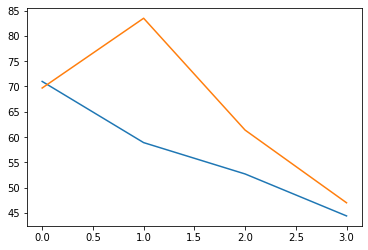

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
nn_result = [71, 58.9, 52.7, 44.4]
np_result = [69.7, 83.5, 61.38, 47]
plt.plot(nn_result)
plt.plot(np_result)



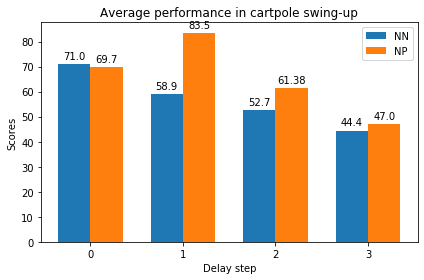

In [9]:
labels = ['0', '1', '2', '3']
nn_result = [71, 58.9, 52.7, 44.4]
np_result = [69.7, 83.5, 61.38, 47]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, nn_result, width, label='NN')
rects2 = ax.bar(x + width/2, np_result, width, label='NP')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Average performance in cartpole swing-up')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Delay step')
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

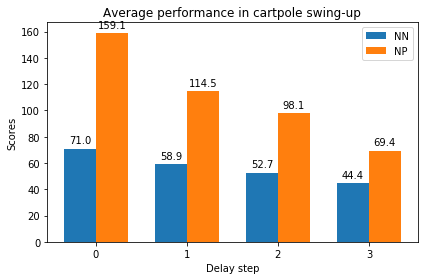

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
labels = ['0', '1', '2', '3']
nn_result = [71, 58.9, 52.7, 44.4]
np_result = [159.1, 114.5, 98.1, 69.4]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, nn_result, width, label='NN')
rects2 = ax.bar(x + width/2, np_result, width, label='NP')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Average performance in cartpole swing-up')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Delay step')
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()